In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import torch
import os
import hydra

import numpy as np
import pandas as pd
import gymnasium as gym
import lightning.pytorch as pl
import matplotlib.pyplot as plt

from torch import nn
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch import loggers as pl_loggers
from hydra import initialize, initialize_config_module, initialize_config_dir, compose
from omegaconf import OmegaConf

from prnn.utils.data import generate_trajectories, create_dataloader
from prnn.utils.env import make_env
# from prnn.utils.agent import RandomActionAgent, RandomHDAgent, RatInABoxAgent
from prnn.utils.predictiveNet import PredictiveNet
from prnn.examples.Miniworld.VAE import RatDataModule, VarAutoEncoder
from prnn.utils.agent import MiniworldRandomAgent

/home/mila/a/aleksei.efremov/venvs/PredictiveReplay_39/lib/python3.9/site-packages/gymnasium/envs/registration.py:694: UserWarning: WARN: Overriding environment MiniGrid-BlockedUnlockPickup-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/home/mila/a/aleksei.efremov/venvs/PredictiveReplay_39/lib/python3.9/site-packages/gymnasium/envs/registration.py:694: UserWarning: WARN: Overriding environment MiniGrid-LavaCrossingS9N1-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/home/mila/a/aleksei.efremov/venvs/PredictiveReplay_39/lib/python3.9/site-packages/gymnasium/envs/registration.py:694: UserWarning: WARN: Overriding environment MiniGrid-LavaCrossingS9N2-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/home/mila/a/aleksei.efremov/venvs/PredictiveReplay_39/lib/python3.9/site-packages/gymnasium/envs/registration.py:694: UserWarning: WARN

In [2]:
from prnn.examples.RatEnvironment import make_rat_env

riab_env = make_rat_env("RiaB-LRoom")
agent = MiniworldRandomAgent(riab_env)

/home/mila/a/aleksei.efremov/venvs/PredictiveReplay_39/lib/python3.9/site-packages/ratinabox/utils.py:823: UserWarning: Cannot collect the default_params dictionaries, as MiniworldRandomAgent does not have the class attribute 'default_params' defined in its preamble. (Can be just an empty dictionary, i.e.: default_params = dict().)
  warnings.warn(
/home/mila/a/aleksei.efremov/venvs/PredictiveReplay_39/lib/python3.9/site-packages/ratinabox/utils.py:878: UserWarning: Cannot check the keys in the params dictionary, as <class 'prnn.utils.agent.MiniworldRandomAgent'> does not have a class attribute 'default_params' defined in its preamble. (Can be just an empty dictionary, i.e.: default_params = dict().)
  warnings.warn(


In [3]:
tr = agent.generateActionSequence(np.array([0,0]), 0, 10)

In [4]:
tr.shape

(2, 10)

In [17]:
with initialize(version_base=None, config_path="config/"):
    config = compose("config")

In [18]:
ae = VarAutoEncoder(
        learning_rate=config["vae"]["learning_rate"],
        net_config=config["vae"]["net_config"].values(),
        in_channels=config["vae"]["in_channels"],
        latent_dim=config["vae"]["latent_dim"],
    )

In [11]:
# ae_path = os.path.join(os.path.expandvars('${SCRATCH}'), 'Data', 'test', 'checkpoints', 'rat_ae-epoch=00-train_loss=0.076870.ckpt')
ae_path = os.path.join(os.path.expandvars('${SCRATCH}'), 'Data', 'Miniworld', 'checkpoints', 'rat_ae-epoch=08-train_loss=0.019058.ckpt')
ae = VarAutoEncoder.load_from_checkpoint(
        ae_path, in_channels=config["vae"]["in_channels"],
        net_config=config["vae"]["net_config"].values()
    )

In [4]:
from PIL import Image
import torchvision.transforms as transforms

# Open the PNG image
image_path = os.path.join(os.path.expandvars('${SCRATCH}'), 'Data', 'Miniworld', 'data', '0', 'Images', '0.png')
image = Image.open(image_path)

# Define a transform to convert the image to a PyTorch tensor
transform = transforms.ToTensor()

# Apply the transform
image_tensor = transform(image)
image_tensor = image_tensor.unsqueeze(0)  # Add batch dimension
image_tensor = image_tensor.to(ae.device)

In [12]:
image_tensor.shape

torch.Size([1, 3, 64, 64])

In [12]:
pred = ae(image_tensor)[0]

In [13]:
image_to_plot = image_tensor.squeeze().permute(1, 2, 0).detach().cpu().numpy()
pred_to_plot = pred.squeeze().permute(1, 2, 0).detach().cpu().numpy()

In [15]:
image_to_plot.shape

(64, 64, 3)

In [18]:
image_to_plot.transpose(2, 0, 1).shape

(3, 64, 64)

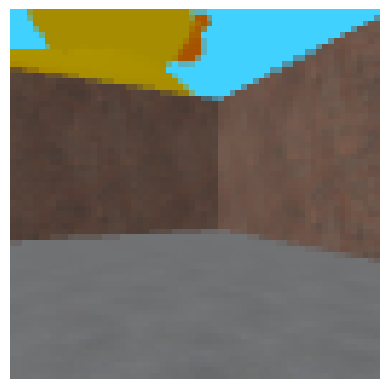

In [14]:
plt.imshow(image_to_plot)
plt.axis('off')  # Turn off axis
plt.show()

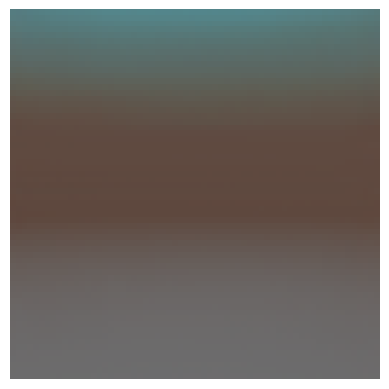

In [15]:
plt.imshow(pred_to_plot)
plt.axis('off')  # Turn off axis
plt.show()

In [ ]:
import imageio

images = []
for i in range(1000):
    images.append(imageio.imread(f"/network/scratch/a/aleksei.efremov/Data/test/data/0/Images/{i}.png"))

imageio.mimsave('movie.gif', images, fps=10, loop=10)

In [20]:
!xvfb-run -a -s '-screen 0 1024x768x24' python3 test.py

/home/mila/a/aleksei.efremov/venvs/PredictiveReplay_39/lib/python3.9/site-packages/gymnasium/envs/registration.py:694: UserWarning: WARN: Overriding environment MiniGrid-BlockedUnlockPickup-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/home/mila/a/aleksei.efremov/venvs/PredictiveReplay_39/lib/python3.9/site-packages/gymnasium/envs/registration.py:694: UserWarning: WARN: Overriding environment MiniGrid-LavaCrossingS9N1-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/home/mila/a/aleksei.efremov/venvs/PredictiveReplay_39/lib/python3.9/site-packages/gymnasium/envs/registration.py:694: UserWarning: WARN: Overriding environment MiniGrid-LavaCrossingS9N2-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/home/mila/a/aleksei.efremov/venvs/PredictiveReplay_39/lib/python3.9/site-packages/gymnasium/envs/registration.py:694: UserWarning: WARN

In [ ]:
%run trainNet_prnn.py --savefolder='test/' --pRNNtype='thRNN_5win' \
        --sparsity=0.1 --mean_std_ratio=1 --eg_weight_decay=1e-8 --eg_lr=2e-3 \
        --env='MiniGrid-DonutLava-Long-v0' --env_package='farama-minigrid' --agent='RandomActionAgent' \
        --seqdur=1000 --lr=2e-3 --numepochs=6 --numtrials=1024 --hiddensize=500 --noisestd=0.05 \
        --bias_lr=0.2 --trainBias --ntimescale=2 --actenc='SpeedHD' --batch_size=2 --datasetSize=10240 \
        --datasetfolder='/network/scratch/a/aleksei.efremov/Data' --namext='SpeedHD' -s=8 --saveTrainData

In [ ]:
%run trainNet_prnn.py --savefolder='test/' --pRNNtype='multRNN_5win_i1_o0' \
        --sparsity=0.1 --mean_std_ratio=1 --eg_weight_decay=1e-8 --eg_lr=2e-3 \
        --env='RiaB-LRoom' --env_package='ratinabox_colors_grid' --agent='RatInABoxAgent' \
        --seqdur=500 --lr=2e-3 --numepochs=2 --numtrials=1024 --hiddensize=500 --noisestd=0.05 \
        --bias_lr=0.2 --trainBias --ntimescale=2 --actenc='ContSpeedOnehotHD' --batch_size=2 --datasetSize=10240 \
        --datasetfolder='/network/scratch/a/aleksei.efremov/Data' --namext='ContSpeedOnehotHD' -s=8 --saveTrainData --use_dataloader

In [ ]:
%run trainNet_prnn.py --savefolder='test/' --pRNNtype='multRNN_5win_i0_o01' \
        --sparsity=0.1 --mean_std_ratio=1 --eg_weight_decay=1e-8 --eg_lr=2e-3 \
        --env='cheeseboard' --env_package='ratinabox_colors_Reward' --agent='RatInABoxAgent' \
        --seqdur=500 --lr=2e-3 --numepochs=2 --numtrials=1024 --hiddensize=500 --noisestd=0.05 \
        --bias_lr=0.2 --trainBias --ntimescale=2 --actenc='ContSpeedOnehotHD' --batch_size=2 --datasetSize=10240 \
        --datasetfolder='/network/scratch/a/aleksei.efremov/Data' --namext='tmp_datafolder' -s=8 --saveTrainData --custom_FoV --use_dataloader

In [2]:
env = make_env(env_key='LRoom-18x18-v0', package='farama-minigrid', act_enc='OnehotHD')
agent = RandomActionAgent(env.action_space, np.array([0.15,0.15,0.6,0.1,0,0,0]))

/home/mila/a/aleksei.efremov/venvs/PredictiveReplay_39/lib/python3.9/site-packages/gymnasium/utils/passive_env_checker.py:159: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
/home/mila/a/aleksei.efremov/venvs/PredictiveReplay_39/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.get_frame to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.get_frame` for environment variables or `env.get_wrapper_attr('get_frame')` that will search the reminding wrappers.
  logger.warn(
/home/mila/a/aleksei.efremov/venvs/PredictiveReplay_39/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.grid to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.grid` for environment variables or `env.get_wrapper_attr

In [3]:
pN = PredictiveNet(env, 'thRNN_5win_prevAct')

In [5]:
o,a,s,r=pN.collectObservationSequence(env, agent, 10)

/home/mila/a/aleksei.efremov/venvs/PredictiveReplay_39/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.get_frame to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.get_frame` for environment variables or `env.get_wrapper_attr('get_frame')` that will search the reminding wrappers.
  logger.warn(
/home/mila/a/aleksei.efremov/venvs/PredictiveReplay_39/lib/python3.9/site-packages/gymnasium/utils/passive_env_checker.py:159: UserWarning: WARN: The obs returned by the `step()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")


In [4]:
obs, act, state, render = env.collectObservationSequence(agent, 10)

In [8]:
pred,_,_ = pN.predict(obs,act)

In [2]:
# env = make_env(env_key='RiaB-LRoom', package='ratinabox_remix', act_enc='ContSpeedOnehotHD')
# env = make_env(env_key='RiaB-LRoom', package='ratinabox_grid', act_enc='ContSpeedOnehotHD')
env = make_env(env_key='RiaB-LRoom', package='ratinabox_colors_grid', act_enc='ContSpeedOnehotHD')
agent = RatInABoxAgent('Vasya')

/home/mila/a/aleksei.efremov/pRNN/prnn/utils/Shell.py:424: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  facecolor = matplotlib.cm.get_cmap(self.env.object_colormap)


In [ ]:
env = make_env(env_key='RiaB-LRoom', package='ratinabox_colors_grid', act_enc='ContSpeedOnehotHD',
            #    FoV_params={"spatial_resolution": 0.05,
            #                "angle_range": [0, 30],
            #                "distance_range": [0.0, 1.2],
            #                "beta": 10,
            #                "walls_occlude": False
                           }

               )
agent = RatInABoxAgent('Vasya')

/home/mila/a/aleksei.efremov/pRNN/prnn/utils/Shell.py:424: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  facecolor = matplotlib.cm.get_cmap(self.env.object_colormap)


In [26]:
obs, act, _, _ = env.collectObservationSequence(agent, 10)

In [27]:
obs[0].shape

torch.Size([1, 11, 180])

In [28]:
prednet = PredictiveNet(env, pRNNtype='multRNN_5win_i01_o01')

In [29]:
obs_pred, state, render = prednet.predict(obs, act)

In [ ]:
prednet.plotObservationSequence(obs, render, obs_pred, state, timesteps=range(4,10))

In [10]:
prednet.plotSpontaneousTrajectory(0,1,2000,plot=False)

/home/mila/a/aleksei.efremov/pRNN/prnn/utils/predictiveNet.py:422: DeprecationWarning: invalid escape sequence \{
  print(f"loss: {steploss:>.2}, sparsity: {sparsity:>.2}, meanrate: {meanrate:>.2} [{bb:>5d}\{num_trials:>5d}]")
/home/mila/a/aleksei.efremov/pRNN/prnn/utils/predictiveNet.py:449: DeprecationWarning: invalid escape sequence \{
  print(f"loss: {steploss:>.2}, sparsity: {sparsity:>.2}, meanrate: {meanrate:>.2} [{bb:>5d}\{num_trials:>5d}]")


UnboundLocalError: local variable 'decoded' referenced before assignment

In [4]:
prednet.trainingEpoch(env, agent)

Training pRNN on cuda...
loss: 0.2, sparsity: 0.095, meanrate: 0.38 [    0\  100]
loss: 0.13, sparsity: 0.09, meanrate: 0.4 [   10\  100]
loss: 0.11, sparsity: 0.086, meanrate: 0.42 [   20\  100]
loss: 0.1, sparsity: 0.084, meanrate: 0.42 [   30\  100]
loss: 0.09, sparsity: 0.083, meanrate: 0.43 [   40\  100]
loss: 0.09, sparsity: 0.083, meanrate: 0.43 [   50\  100]
loss: 0.089, sparsity: 0.081, meanrate: 0.43 [   60\  100]
loss: 0.085, sparsity: 0.083, meanrate: 0.43 [   70\  100]
loss: 0.087, sparsity: 0.082, meanrate: 0.43 [   80\  100]
loss: 0.085, sparsity: 0.084, meanrate: 0.43 [   90\  100]
loss: 0.079, sparsity: 0.084, meanrate: 0.42 [   99\  100]
Epoch Complete. Back to the cpu


In [4]:
place_fields, SI, decoder = prednet.calculateSpatialRepresentation(env,agent,
                                                 trainDecoder=True, trainHDDecoder = True,
                                                 saveTrainingData=True, bitsec= False,
                                                 calculatesRSA = True, sleepstd=0.03)

/home/mila/a/aleksei.efremov/venvs/PredictiveReplay_39/lib/python3.9/site-packages/pynapple/process/tuning_curves.py:378: RuntimeWarning: invalid value encountered in true_divide
  fxfr = fx / fr
/home/mila/a/aleksei.efremov/venvs/PredictiveReplay_39/lib/python3.9/site-packages/pynapple/process/tuning_curves.py:389: RuntimeWarning: invalid value encountered in true_divide
  SI = SI / fr[:, 0, 0]
/home/mila/a/aleksei.efremov/pRNN/prnn/analysis/representationalGeometryAnalysis.py:277: RuntimeWarning: invalid value encountered in true_divide
  hist2 = hist2/np.sum(hist2,axis=0)
/home/mila/a/aleksei.efremov/pRNN/prnn/analysis/SpatialTuningAnalysis.py:147: RuntimeWarning: invalid value encountered in true_divide
  EVSpace = 1 - np.var(spaceRemoved,axis=0) / (np.var(WAKE_h,axis=0))


Training Decoder on cuda...
loss: 5.634298 [    0\ 5000]
loss: 1.876123 [  500\ 5000]
loss: 1.292742 [ 1000\ 5000]
loss: 1.000172 [ 1500\ 5000]
loss: 0.837390 [ 2000\ 5000]
loss: 0.717212 [ 2500\ 5000]
loss: 0.641766 [ 3000\ 5000]
loss: 0.576236 [ 3500\ 5000]
loss: 0.527557 [ 4000\ 5000]
loss: 0.487170 [ 4500\ 5000]
loss: 0.448588 [ 4999\ 5000]
Training Complete. Back to the cpu
Training Decoder on cuda...
loss: 2.631562 [    0\ 5000]
loss: 0.602399 [  500\ 5000]
loss: 0.500682 [ 1000\ 5000]
loss: 0.449776 [ 1500\ 5000]
loss: 0.424104 [ 2000\ 5000]
loss: 0.418588 [ 2500\ 5000]
loss: 0.392879 [ 3000\ 5000]
loss: 0.384710 [ 3500\ 5000]
loss: 0.382396 [ 4000\ 5000]
loss: 0.363774 [ 4500\ 5000]
loss: 0.354847 [ 4999\ 5000]
Training Complete. Back to the cpu


In [3]:
generate_trajectories(env, agent, n_trajs=10, seq_length=500, folder='Data')

Found existing data, will generate more data if needed
Not enough trajectories, generating more data...


/home/mila/a/aleksei.efremov/pRNN/prnn/utils/Shell.py:391: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([state['agent_pos'][-1], act[-1,1:]])


In [2]:
prednet = PredictiveNet.loadNet('Hadrien/multRNN_5win_i0_o01--s8')

Net Loaded from pathname


In [3]:
prednet.pRNN.to(device='cpu')

multRNN_5win_i0_o01(
  (actpad): ConstantPad1d(padding=(0, 0, 0, 0), value=0)
  (batched_actpad): ConstantPad1d(padding=(0, 0, 0, 0, 0, 0), value=0)
  (droplayer): Dropout(p=0.15, inplace=False)
  (rnn): thetaRNNLayer(
    (cell): LayerNormRNNCell(
      (layernorm): LayerNorm()
      (actfun): ReLU()
    )
  )
  (outlayer): Sequential(
    (0): Linear(in_features=500, out_features=183, bias=False)
    (1): Sigmoid()
  )
)

In [4]:
prednet.saveNet('Hadrien/multRNN_5win_i0_o01--cpu')

Net Saved to pathname


In [12]:
prednet.env_shell.dataLoader

In [24]:
i = iter(prednet.env_shell.dataLoader)

In [25]:
o, a, s = next(i)

In [20]:
s.shape

torch.Size([8, 1, 500, 13])

In [26]:
import sys

print(sys.getsizeof(o))
print(sys.getsizeof(a))
print(sys.getsizeof(s))

80
80
80


In [4]:
create_dataloader(env=env, agent=agent, n_trajs=10000, folder='Data', batch_size=1, seq_length=500, num_workers=0)

Found existing data, will generate more data if needed


In [5]:
DL_iterator = iter(env.dataLoader)

In [6]:
predictiveNet = PredictiveNet(env)

In [18]:
predictiveNet.useDataLoader = True
predictiveNet.trainingEpoch(env, agent,
                            sequence_duration=500,
                            num_trials=10,
                            batch_size=1)

# predictiveNet.useDataLoader = False
# predictiveNet.trainingEpoch(env, agent,
#                             sequence_duration=500,
#                             num_trials=10,
#                             batch_size=1)

Training pRNN on cuda...
loss: 0.042, sparsity: 0.32, meanrate: 0.69 [    0\   10]
loss: 0.023, sparsity: 0.28, meanrate: 0.26 [    1\   10]
loss: 0.02, sparsity: 0.28, meanrate: 0.22 [    2\   10]
loss: 0.02, sparsity: 0.28, meanrate: 0.21 [    3\   10]
loss: 0.02, sparsity: 0.28, meanrate: 0.21 [    4\   10]
loss: 0.021, sparsity: 0.28, meanrate: 0.21 [    5\   10]
loss: 0.019, sparsity: 0.28, meanrate: 0.26 [    6\   10]
loss: 0.019, sparsity: 0.29, meanrate: 0.25 [    7\   10]
loss: 0.019, sparsity: 0.29, meanrate: 0.38 [    8\   10]
loss: 0.019, sparsity: 0.27, meanrate: 0.23 [    9\   10]
Epoch Complete. Back to the cpu


In [14]:
obs, act, _, _ = predictiveNet.collectObservationSequence(env, agent, 500, dataloader=True)

In [19]:
obs, act = env.dataLoader.dataset[0]

In [23]:
obs = obs[None]
act = act[None]

In [8]:
obs2, act2, _, render = predictiveNet.collectObservationSequence(env, agent, 500, includeRender=True, dataloader=False)

In [11]:
pred, _, _ = predictiveNet.predict(obs, act)

In [31]:
pred2, _, _ = predictiveNet.predict(obs2, act2)

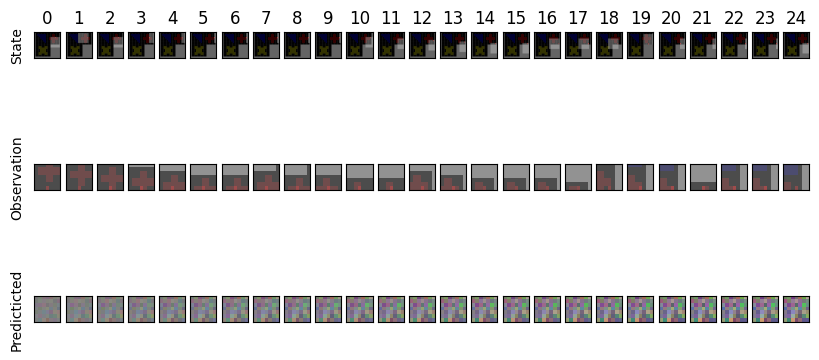

In [24]:
predictiveNet.plotObservationSequence(obs, render, pred, timesteps=range(0,25))

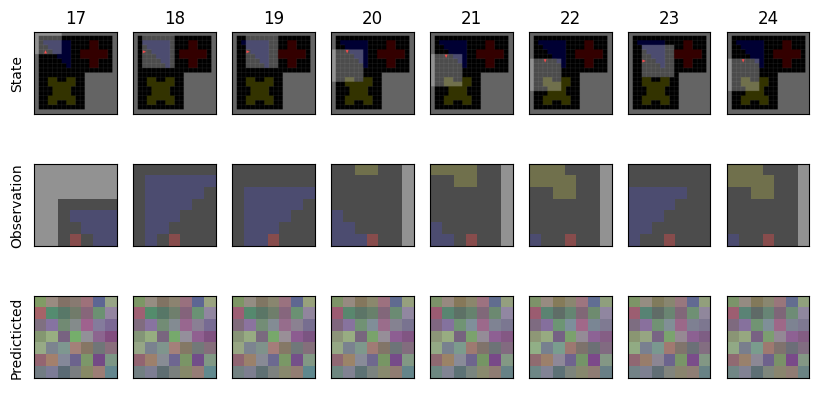

In [32]:
predictiveNet.plotObservationSequence(obs2, render, pred2, timesteps=range(17,25))

In [27]:
act = np.load('Data/MiniGrid-LRoom-18x18-v0-RandomActionAgent/1/act.npy')

In [28]:
act.shape

(1, 500, 11)